In [36]:
!pip install torch numpy matplotlib scikit-learn geomstats
!pip install tsne-torch

import time
import torch
import warnings
import geomstats
import tsne_torch
import numpy as np
import torch as th
import seaborn as sns
import scipy.stats as stats
import hyptorch.pmath as pmath
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import linalg
from sklearn.manifold import TSNE
from sklearn.manifold import _utils
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from scipy.spatial.distance import pdist
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix, issparse
from sklearn.manifold import _barnes_hut_tsne
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from geomstats.geometry.hyperbolic import Hyperbolic
from geomstats.geometry.hypersphere import Hypersphere
from sklearn.utils.validation import check_non_negative
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.utils._openmp_helpers import _openmp_effective_n_threads

MACHINE_EPSILON = np.finfo(np.double).eps

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.get_device_name()}")
    print(f"Device count: {torch.cuda.device_count()}")

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

sns.set_style("whitegrid")
plt.style.use('default')

CUDA available: True
Current device: NVIDIA A100-SXM4-40GB
Device count: 1


## Visualizing Mixed-Curvature Data Through Geometric Decomposition

In [37]:
def euclidean_distance(x, y):
    """Compute Euclidean distance between points."""
    return np.sqrt(np.sum((x - y) ** 2, axis=-1))

def hyperbolic_distance(x, y, manifold=None):
    """Compute hyperbolic distance between points."""
    if manifold is None:
        manifold = Hyperbolic(dim=x.shape[-1]-1)  # -1 for Poincare ball model
    return manifold.dist(x, y)

def spherical_distance(x, y, manifold=None):
    """Compute spherical distance between points."""
    if manifold is None:
        manifold = Hypersphere(dim=x.shape[-1]-1)
    return manifold.dist(x, y)

# Constants
RANDOM_STATE = 42
N_COMPONENTS = 2
PERPLEXITY = 30
N_ITER = 1000
LEARNING_RATE = 200

# Colors for visualization
COLORS = sns.color_palette("husl", 10)

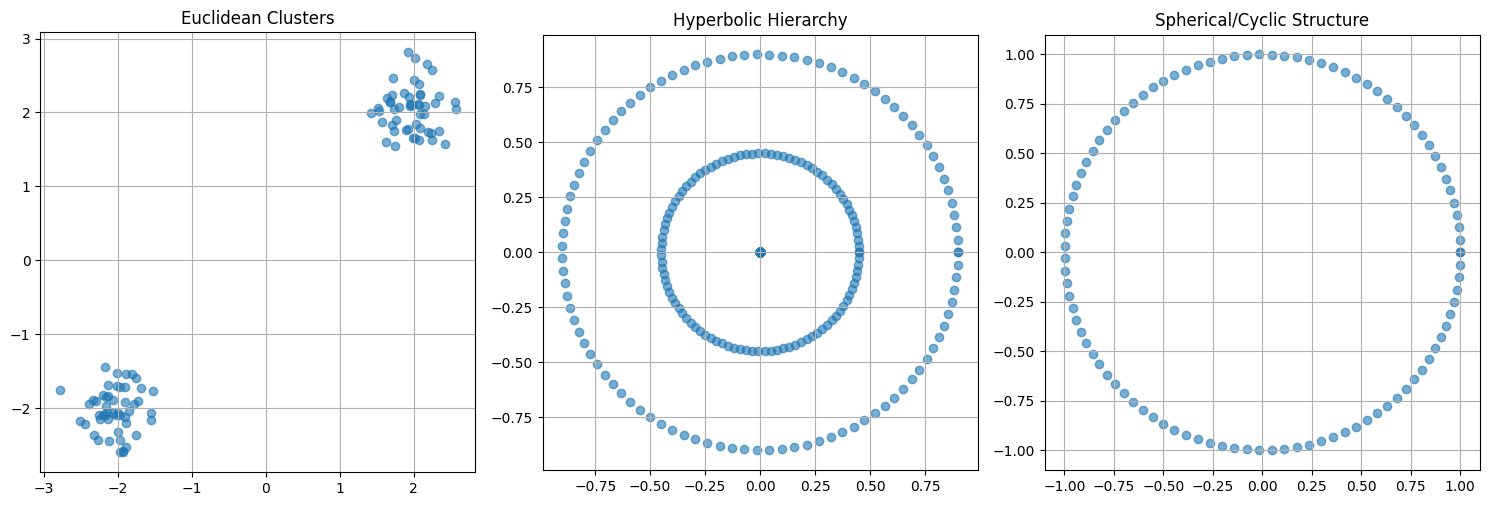

In [38]:
# JUST A DEMO - create a figure with three subplots to illustrate different geometric structures
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Example 1: Euclidean clusters
n_points = 100
cluster1 = np.random.normal(loc=[-2, -2], scale=0.3, size=(n_points//2, 2))
cluster2 = np.random.normal(loc=[2, 2], scale=0.3, size=(n_points//2, 2))
clusters = np.vstack([cluster1, cluster2])
ax1.scatter(clusters[:, 0], clusters[:, 1], alpha=0.6)
ax1.set_title('Euclidean Clusters')

# Example 2: Hyperbolic tree (simplified visualization)
theta = np.linspace(0, 2*np.pi, n_points)
r = np.linspace(0, 0.9, 3)  # levels of the tree
points = []
for radius in r:
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    points.extend(zip(x, y))
points = np.array(points)
ax2.scatter(points[:, 0], points[:, 1], alpha=0.6)
ax2.set_title('Hyperbolic Hierarchy')

# Example 3: Spherical/cyclic data
theta = np.linspace(0, 2*np.pi, n_points)
x = np.cos(theta)
y = np.sin(theta)
ax3.scatter(x, y, alpha=0.6)
ax3.set_title('Spherical/Cyclic Structure')

for ax in [ax1, ax2, ax3]:
    ax.set_aspect('equal')
    ax.grid(True)

plt.tight_layout()
plt.show()

### t-SNE Visualization on MNIST (validating Euclidean implementation)

Loaded MNIST data with shape: (1000, 784)
Number of classes: 10


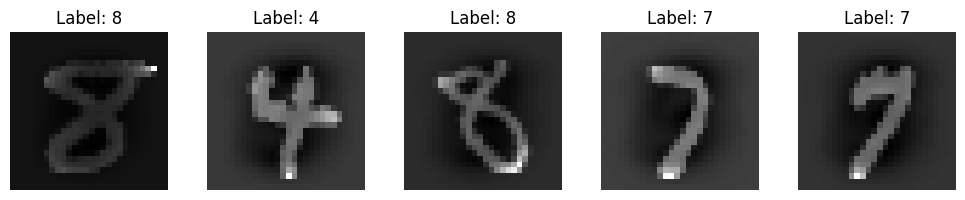

In [39]:
def load_mnist(n_samples=10000, random_state=42):
    # Load MNIST
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

    # Convert to float32 for faster processing
    X = X.astype('float32')

    # Normalize the data
    X = StandardScaler().fit_transform(X)

    # Subsample if needed
    if n_samples < X.shape[0]:
        np.random.seed(random_state)
        idx = np.random.choice(X.shape[0], n_samples, replace=False)
        X = X[idx]
        y = y[idx]

    return X, y

# Load a subset of MNIST for initial testing
X_mnist, y_mnist = load_mnist(n_samples=1000)

print(f"Loaded MNIST data with shape: {X_mnist.shape}")
print(f"Number of classes: {len(np.unique(y_mnist))}")

# Visualize a few digits to verify the data
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_mnist[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_mnist[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [40]:
def run_euclidean_tsne(X, perplexity=30, n_components=2, random_state=42):
    """
    Run t-SNE in Euclidean space using scikit-learn implementation

    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Input data
    perplexity : float, default=30
        Perplexity parameter for t-SNE
    n_components : int, default=2
        Dimension of the embedded space
    random_state : int, default=42
        Random state for reproducibility

    Returns:
    --------
    X_embedded : array-like of shape (n_samples, n_components)
        Embedded data in lower dimensional space
    """
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        random_state=random_state,
        init='pca'  # Using PCA initialization for better global structure
    )

    t0 = time.time()
    X_embedded = tsne.fit_transform(X)
    duration = time.time() - t0

    print(f"t-SNE embedding computed in {duration:.2f} seconds")
    return X_embedded

# Load and preprocess MNIST data
X_mnist, y_mnist = load_mnist(n_samples=1000)
print(f"MNIST data shape: {X_mnist.shape}")

# Run t-SNE
X_embedded = run_euclidean_tsne(X_mnist)

MNIST data shape: (1000, 784)
t-SNE embedding computed in 2.36 seconds


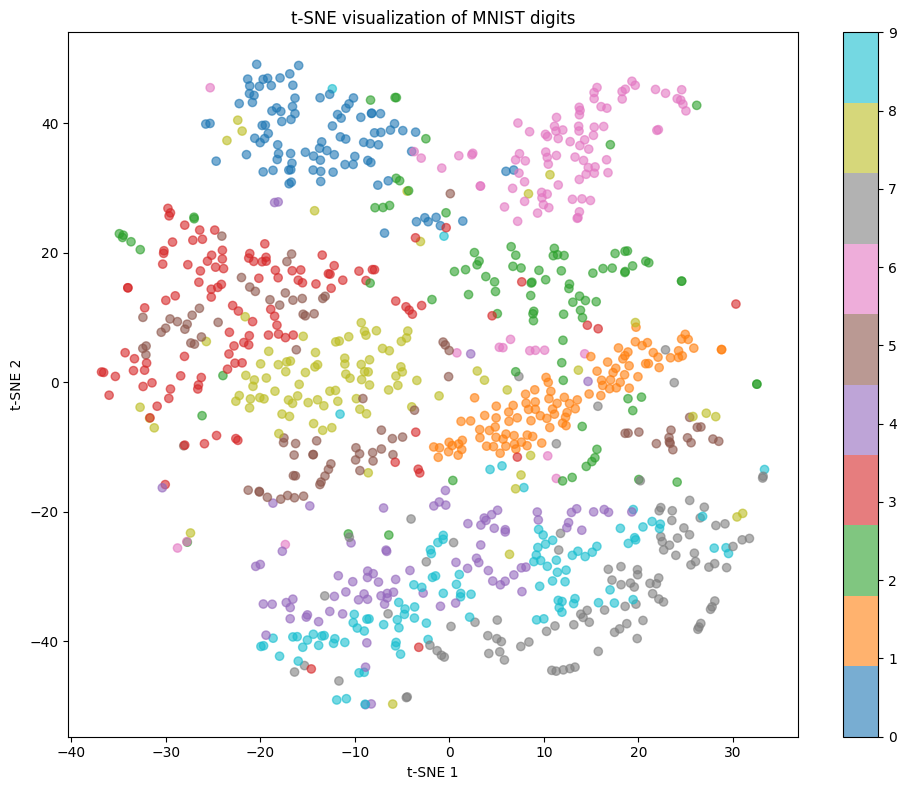

In [41]:
def plot_embedding(X_embedded, y, title=None):
    """
    Plot the embedded data with colors based on labels

    Parameters:
    -----------
    X_embedded : array-like of shape (n_samples, 2)
        Embedded data in 2D
    y : array-like of shape (n_samples,)
        Labels for coloring
    title : str, optional
        Title for the plot
    """
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        X_embedded[:, 0],
        X_embedded[:, 1],
        c=y.astype(int),
        cmap='tab10',
        alpha=0.6
    )
    plt.colorbar(scatter)

    if title is not None:
        plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.tight_layout()
    plt.show()

# Visualize the t-SNE embedding
plot_embedding(X_embedded, y_mnist, "t-SNE visualization of MNIST digits")

### CO-SNE Visualization on Synthetic Point Clusters (validating hyperbolic implementation)

In [42]:
# Sklearn t-SNE modified for hyperbolic embeddings.
def _joint_probabilities(distances, desired_perplexity, verbose):
    # Compute conditional probabilities such that they approximately match
    # the desired perplexity
    distances = distances.astype(np.float32, copy=False)
    # print("distances", distances.shape, distances[0])
    conditional_P = _utils._binary_search_perplexity(
        distances, desired_perplexity, verbose)
    P = conditional_P + conditional_P.T
    # print("P == P[0][0]",P.shape, np.count_nonzero(P == P[0][1]))
    # print("cond P", conditional_P.shape, np.count_nonzero(conditional_P == conditional_P[0][1]), conditional_P)
    #print("cond P + P.T", P)
    sum_P = np.maximum(np.sum(P), MACHINE_EPSILON)
    P = np.maximum(squareform(P) / sum_P, MACHINE_EPSILON)
    # print("P final", P)
    return P


def _joint_probabilities_nn(distances, desired_perplexity, verbose):
    t0 = time()
    # Compute conditional probabilities such that they approximately match
    # the desired perplexity
    distances.sort_indices()
    n_samples = distances.shape[0]
    distances_data = distances.data.reshape(n_samples, -1)
    distances_data = distances_data.astype(np.float32, copy=False)
    conditional_P = _utils._binary_search_perplexity(
        distances_data, desired_perplexity, verbose)
    assert np.all(np.isfinite(conditional_P)), \
        "All probabilities should be finite"

    # Symmetrize the joint probability distribution using sparse operations
    P = csr_matrix((conditional_P.ravel(), distances.indices,
                    distances.indptr),
                   shape=(n_samples, n_samples))
    P = P + P.T

    # Normalize the joint probability distribution
    sum_P = np.maximum(P.sum(), MACHINE_EPSILON)
    P /= sum_P

    assert np.all(np.abs(P.data) <= 1.0)
    if verbose >= 2:
        duration = time() - t0
        print("[t-SNE] Computed conditional probabilities in {:.3f}s"
              .format(duration))
    return P


def hdist_grad(x, v, sqnormx, sqnormv, sqdist, eps):
        alpha = (1 - sqnormx)
        beta = (1 - sqnormv)
        z = 1 + 2 * sqdist / (alpha * beta)
        a = ((sqnormv - 2 * th.sum(x * v, dim=-1) + 1) / th.pow(alpha, 2))\
            .unsqueeze(-1).expand_as(x)
        a = a * x - v / alpha.unsqueeze(-1).expand_as(v)
        z = th.sqrt(th.pow(z, 2) - 1)
        z = th.clamp(z * beta, min=eps).unsqueeze(-1)
        return 4 * a / z.expand_as(x)


def _kl_divergence(params, P, embs, learning_rate_for_h_loss, degrees_of_freedom, n_samples, n_components,
                   skip_num_points=0, compute_error=True, student_t_gamma=1.0):

    X_embedded = params.reshape(n_samples, n_components)
    # Q is a heavy-tailed distribution: Student's t-distribution

    # HTSNE: Use hyperbolic distance for calculating Q
    X_tensor = th.from_numpy(X_embedded)
    dist = pmath.dist_matrix(X_tensor, X_tensor, c=1)

    #print ("dist :", dist[0,:])

    dist = dist / (student_t_gamma**2)


    dist = squareform(dist.numpy(), checks=False)


    dist /= degrees_of_freedom
    dist += 1.

    dist **= (degrees_of_freedom + 1.0) / -2.0


    square_dist = squareform(dist )


    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)


    square_Q = squareform(Q)

    # Optimization trick below: np.dot(x, y) is faster than
    # np.sum(x * y) because it calls BLAS

    # Cost for maintaining magnitude
    mag_cost = np.mean((np.linalg.norm(embs, axis=1)**2 - np.linalg.norm(X_embedded, axis=1)**2)**2)


    # Gradient contributed by mag_cost
    mag_grad_scale =  (-4 * (np.linalg.norm(embs, axis=1)**2 - np.linalg.norm(X_embedded, axis=1)**2))

    mag_grad = mag_grad_scale[:,np.newaxis] * X_embedded


    # Objective: C (Kullback-Leibler divergence of P and Q)
    if compute_error:
        #print("P, log p/q", np.mean(P), np.mean(np.log(np.maximum(P, MACHINE_EPSILON) / Q)))
        kl_divergence = 2.0 * np.dot(
            P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    else:
        kl_divergence = np.nan


    # Gradient: dC/dY
    # pdist always returns double precision distances. Thus we need to take
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)

    PQd = squareform((P - Q) * dist)


    grad_per_point = np.ndarray((n_samples, n_samples, n_components))

    grad_sign = np.ndarray((n_samples, n_samples))


    y_j_norms = np.linalg.norm(X_embedded, axis=1)

    beta = 1. - y_j_norms


    for i in range(skip_num_points, n_samples):

        # HTSNE: Calculate partial derivative of hyperbolic distance with respect to y_i

        alpha = 1. - np.linalg.norm(X_embedded[i])

        alphabeta = alpha * beta

        gamma = 1 + ((2. / alphabeta) * (np.linalg.norm(X_embedded[i] - X_embedded, axis = 1) ** 2.))


        dot_products = np.dot(X_embedded, X_embedded[i])

        com1 = (4. / (beta * np.sqrt(gamma**2. - 1. + 1e-10)))


        com2 = (np.outer((y_j_norms**2. - 2.*dot_products + 1.) / (alpha**2. + 1e-5), X_embedded[i])  - X_embedded/alpha)


        dd_dy = com1[:, np.newaxis] * com2

        dim_ = dd_dy[i].shape[0]
        dd_dy[i] = [0] * dim_


        grad[i] = np.sum(PQd[i][:, np.newaxis] * dd_dy,axis=0)

        grad_sign[i] = np.sign(np.ravel(PQd[i]))
        grad_per_point[i] = np.ravel(PQd[i], order='K')[:, np.newaxis] * dd_dy


    # HTSNE: Scale gradients based on norm of embedding
    grad = ((1. - np.linalg.norm(X_embedded, axis=1) ** 2) ** 2)[:, np.newaxis] * grad / 4


    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom

    grad *= c

    # Magnitude loss added
    #grad *= (1 - lam)
    grad_norm = np.linalg.norm(grad)

    mag_grad_norm= np.linalg.norm(mag_grad)


    split_cost = (kl_divergence, mag_cost, grad_norm, mag_grad_norm)

    grad     = grad.ravel()
    mag_grad =  mag_grad.ravel()


    s = np.sign(PQd[0, :])

    return kl_divergence + mag_cost, grad, learning_rate_for_h_loss*mag_grad, split_cost, grad_per_point, grad_sign


def _kl_divergence_bh(params, P, degrees_of_freedom, n_samples, n_components,
                      angle=0.5, skip_num_points=0, verbose=False,
                      compute_error=True, num_threads=1):

    params = params.astype(np.float32, copy=False)
    X_embedded = params.reshape(n_samples, n_components)

    val_P = P.data.astype(np.float32, copy=False)
    neighbors = P.indices.astype(np.int64, copy=False)
    indptr = P.indptr.astype(np.int64, copy=False)

    grad = np.zeros(X_embedded.shape, dtype=np.float32)
    error = _barnes_hut_tsne.gradient(val_P, X_embedded, neighbors, indptr,
                                      grad, angle, n_components, verbose,
                                      dof=degrees_of_freedom,
                                      compute_error=compute_error,
                                      num_threads=num_threads)
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad = grad.ravel()
    grad *= c

    return error, grad


def _gradient_descent(objective, p0, it, n_iter,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-8, verbose=0, args=None, kwargs=None):
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()

    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(float).max
    best_error = np.finfo(float).max
    best_iter = i = it

    # HTSNE: Keep track of all errors for debugging
    split_errors = []
    errors = []
    grads = []
    output_embs = []
    grad_pers = []
    grad_signs = []
    tic = time()

    for i in range(it, n_iter):

        if i % 10 == 0 or i < 10:
            output_embs.append((i, p))


        check_convergence = (i + 1) % n_iter_check == 0
        # only compute the error when needed
        kwargs['compute_error'] = True #check_convergence or i == n_iter - 1

        error, grad, mag_grad, split_error, grad_per_point, grad_sign = objective(p, *args, **kwargs)


        errors.append(error)
        grads.append(grad)
        split_errors.append(split_error)
        grad_pers.append(grad_per_point)
        grad_signs.append(grad_sign)
        grad_norm = linalg.norm(grad)


        momentum  = 0.0

        square_p = p.reshape((-1, 2))

        update = -learning_rate * grad - mag_grad

        p += update

        square_grad = update.reshape((-1, 2))

        square_p = p.reshape((-1, 2))


        # HTSNE: Project embeddings if they are outside of ball
        X_embed = p.reshape((-1, 2)) # TODO Fails for higher dims
        for j in range(X_embed.shape[0]):
            x_len = np.linalg.norm(X_embed[j])
            if x_len > 1:
                X_embed[j] = (X_embed[j] / x_len) - 1e-5

        p = X_embed.flatten()

        if check_convergence:
            toc = time()
            duration = toc - tic
            tic = toc

            if verbose >= 2:
                print("[HT-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      " (%s iterations in %0.3fs)"
                      % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                          "during the last %d episodes. Finished."
                          % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                          % (i + 1, grad_norm))
                break

    return p, error, i, errors, output_embs, split_errors, grads, grad_pers, grad_signs


@_deprecate_positional_args
def trustworthiness(X, X_embedded, *, n_neighbors=5, metric='euclidean'):
    r
    dist_X = pairwise_distances(X, metric=metric)
    if metric == 'precomputed':
        dist_X = dist_X.copy()
    # we set the diagonal to np.inf to exclude the points themselves from
    # their own neighborhood
    np.fill_diagonal(dist_X, np.inf)
    ind_X = np.argsort(dist_X, axis=1)
    # `ind_X[i]` is the index of sorted distances between i and other samples
    ind_X_embedded = NearestNeighbors(n_neighbors=n_neighbors).fit(
            X_embedded).kneighbors(return_distance=False)

    # We build an inverted index of neighbors in the input space: For sample i,
    # we define `inverted_index[i]` as the inverted index of sorted distances:
    # inverted_index[i][ind_X[i]] = np.arange(1, n_sample + 1)
    n_samples = X.shape[0]
    inverted_index = np.zeros((n_samples, n_samples), dtype=int)
    ordered_indices = np.arange(n_samples + 1)
    inverted_index[ordered_indices[:-1, np.newaxis],
                   ind_X] = ordered_indices[1:]
    ranks = inverted_index[ordered_indices[:-1, np.newaxis],
                           ind_X_embedded] - n_neighbors
    t = np.sum(ranks[ranks > 0])
    t = 1.0 - t * (2.0 / (n_samples * n_neighbors *
                          (2.0 * n_samples - 3.0 * n_neighbors - 1.0)))
    return t


class TSNE(BaseEstimator):
    # Control the number of exploration iterations with early_exaggeration on
    #_EXPLORATION_N_ITER = 250

    _EXPLORATION_N_ITER = 500

    # Control the number of iterations between progress checks
    _N_ITER_CHECK = 50

    @_deprecate_positional_args
    def __init__(self, n_components=2, *, perplexity=30.0,
                 early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, learning_rate_for_h_loss=1.0, student_t_gamma=1.0,
                 n_iter_without_progress=300, min_grad_norm=1e-7,
                 metric="euclidean", init="random", verbose=0,
                 random_state=None, method='barnes_hut', angle=0.5,
                 n_jobs=None, square_distances='legacy'):
        self.n_components = n_components
        self.perplexity = perplexity
        self.early_exaggeration = early_exaggeration
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.n_iter_without_progress = n_iter_without_progress
        self.min_grad_norm = min_grad_norm
        self.metric = metric
        self.init = init
        self.verbose = verbose
        self.random_state = random_state
        self.method = method
        self.angle = angle
        self.n_jobs = n_jobs
        # TODO Revisit deprecation of square_distances for 1.1-1.3 (#12401)
        self.square_distances = square_distances

        # Lambda value for scaling magnitude loss
        self.learning_rate_for_h_loss = learning_rate_for_h_loss

        self.student_t_gamma = student_t_gamma

    def _fit(self, X, embs, skip_num_points=0):
        """Private function to fit the model using X as training data."""

        if self.method not in ['barnes_hut', 'exact']:
            raise ValueError("'method' must be 'barnes_hut' or 'exact'")
        if self.angle < 0.0 or self.angle > 1.0:
            raise ValueError("'angle' must be between 0.0 - 1.0")
        if self.square_distances not in [True, 'legacy']:
            raise ValueError("'square_distances' must be True or 'legacy'.")
        if self.metric != "euclidean" and self.square_distances is not True:
            warnings.warn(
                FutureWarning
            )
        if self.method == 'barnes_hut':
            X = self._validate_data(X, accept_sparse=['csr'],
                                    ensure_min_samples=2,
                                    dtype=[np.float32, np.float64])
        else:
            X = self._validate_data(X, accept_sparse=['csr', 'csc', 'coo'],
                                    dtype=[np.float32, np.float64])

        if self.metric == "precomputed":
            if isinstance(self.init, str) and self.init == 'pca':
                raise ValueError("The parameter init=\"pca\" cannot be "
                                 "used with metric=\"precomputed\".")
            if X.shape[0] != X.shape[1]:
                raise ValueError("X should be a square distance matrix")

            check_non_negative(X, "TSNE.fit(). With metric='precomputed', X "
                                  "should contain positive distances.")

            if self.method == "exact" and issparse(X):
                raise TypeError(
                    'TSNE with method="exact" does not accept sparse '
                    'precomputed distance matrix. Use method="barnes_hut" '
                    'or provide the dense distance matrix.')

        if self.method == 'barnes_hut' and self.n_components > 3:
            raise ValueError("'n_components' should be inferior to 4 for the "
                             "barnes_hut algorithm as it relies on "
                             "quad-tree or oct-tree.")

        random_state = check_random_state(self.random_state)

        if self.early_exaggeration < 1.0:
            raise ValueError("early_exaggeration must be at least 1, but is {}"
                             .format(self.early_exaggeration))

        n_samples = X.shape[0]


        neighbors_nn = None
        if self.method == "exact":
            # Retrieve the distance matrix, either using the precomputed one or
            # computing it.
            if self.metric == "precomputed":
                distances = X
            else:
                if self.verbose:
                    print("[t-SNE] Computing pairwise distances...")

                if self.metric == "euclidean":
                    distances = pairwise_distances(X, metric=self.metric,
                                                   squared=True)
                else:
                    distances = pairwise_distances(X, metric=self.metric,
                                                   n_jobs=self.n_jobs)

            if np.any(distances < 0):
                raise ValueError("All distances should be positive, the "
                                 "metric given is not correct")

            if self.metric != "euclidean" and self.square_distances is True:

                distances **= 2

            # compute the joint probability distribution for the input space
            P = _joint_probabilities(distances, self.perplexity, self.verbose)
            assert np.all(np.isfinite(P)), "All probabilities should be finite"
            assert np.all(P >= 0), "All probabilities should be non-negative"
            assert np.all(P <= 1), ("All probabilities should be less "
                                    "or then equal to one")
            self.P = P


        else:
            n_neighbors = min(n_samples - 1, int(3. * self.perplexity + 1))

            if self.verbose:
                print("[t-SNE] Computing {} nearest neighbors..."
                      .format(n_neighbors))

            # Find the nearest neighbors for every point
            knn = NearestNeighbors(algorithm='auto',
                                   n_jobs=self.n_jobs,
                                   n_neighbors=n_neighbors,
                                   metric=self.metric)
            t0 = time()
            knn.fit(X)
            duration = time() - t0
            if self.verbose:
                print("[t-SNE] Indexed {} samples in {:.3f}s...".format(
                    n_samples, duration))

            t0 = time()
            distances_nn = knn.kneighbors_graph(mode='distance')
            duration = time() - t0
            if self.verbose:
                print("[t-SNE] Computed neighbors for {} samples "
                      "in {:.3f}s...".format(n_samples, duration))

            # Free the memory used by the ball_tree
            del knn

            if self.square_distances is True or self.metric == "euclidean":
                distances_nn.data **= 2

            # compute the joint probability distribution for the input space
            P = _joint_probabilities_nn(distances_nn, self.perplexity,
                                        self.verbose)

        if isinstance(self.init, np.ndarray):
            X_embedded = self.init
        elif self.init == 'pca':
            pca = PCA(n_components=self.n_components, svd_solver='randomized',
                      random_state=random_state)
            X_embedded = pca.fit_transform(X).astype(np.float32, copy=False)

        elif self.init == 'random':

            X_embedded = 0.01 * random_state.randn(
                n_samples, self.n_components).astype(np.double)

            X_embedded = pmath.project(th.from_numpy(X_embedded)).numpy()

        else:
            raise ValueError("'init' must be 'pca', 'random', or "
                             "a numpy array")

        degrees_of_freedom = max(self.n_components - 1, 1)

        return self._tsne(P, degrees_of_freedom, n_samples,
                          X_embedded=X_embedded,
                          embs = embs,
                          neighbors=neighbors_nn,
                          skip_num_points=skip_num_points)

    def _tsne(self, P, degrees_of_freedom, n_samples, X_embedded, embs,
              neighbors=None, skip_num_points=0):

        """Runs t-SNE."""

        self._EXPLORATION_N_ITER = np.minimum(self.n_iter, self._EXPLORATION_N_ITER)

        params = X_embedded.ravel()

        opt_args = {
            "it": 0,
            "n_iter_check": self._N_ITER_CHECK,
            "min_grad_norm": self.min_grad_norm,
            "learning_rate": self.learning_rate,
            "verbose": self.verbose,
            "kwargs": dict(skip_num_points=skip_num_points, student_t_gamma=self.student_t_gamma),
            "args": [P, embs, 0, degrees_of_freedom, n_samples, self.n_components],
            "n_iter_without_progress": self._EXPLORATION_N_ITER,

            "n_iter": self._EXPLORATION_N_ITER,

            "momentum": 0
        }

        if self.method == 'barnes_hut':
            obj_func = _kl_divergence_bh
            opt_args['kwargs']['angle'] = self.angle
            # Repeat verbose argument for _kl_divergence_bh
            opt_args['kwargs']['verbose'] = self.verbose
            # Get the number of threads for gradient computation here to
            # avoid recomputing it at each iteration.
            opt_args['kwargs']['num_threads'] = _openmp_effective_n_threads()
        else:
            obj_func = _kl_divergence

        # Learning schedule (part 1): do 250 iteration with lower momentum but
        # higher learning rate controlled via the early exaggeration parameter

        P *= self.early_exaggeration

        params, kl_divergence, it, errors1, outs1, splits1, grads1, grads_per1, grad_signs1 = _gradient_descent(obj_func, params, **opt_args)

        if self.verbose:
            print("[t-SNE] KL divergence after %d iterations with early "
                  "exaggeration: %f" % (it + 1, kl_divergence))

        # Learning schedule (part 2): disable early exaggeration and finish
        # optimization with a higher momentum at 0.8
        opt_args["args"][2] = self.learning_rate_for_h_loss
        P /= self.early_exaggeration
        remaining = self.n_iter - self._EXPLORATION_N_ITER

        if it < self._EXPLORATION_N_ITER or remaining > 0:
            opt_args['n_iter'] = self.n_iter
            opt_args['it'] = it + 1
            opt_args['momentum'] = 0
            opt_args['n_iter_without_progress'] = self.n_iter_without_progress
            params, kl_divergence, it, errors2, outs2, splits2, grads2, grads_per2, grad_signs2 = _gradient_descent(obj_func, params,
                                                          **opt_args)

        # Save the final number of iterations
        self.n_iter_ = it

        if self.verbose:
            print("[t-SNE] KL divergence after %d iterations: %f"
                  % (it + 1, kl_divergence))

        X_embedded = params.reshape(n_samples, self.n_components)
        self.kl_divergence_ = kl_divergence

        # HTSNE: store errors in instance variable
        self.errors = errors1 + errors2 #+ errors3
        self.split_errors = splits1 + splits2 #+ splits3
        self.outs = outs1 + outs2 #+ outs3
        self.grads = grads1 + grads2 #+ grads3
        self.grads_per_point = grads_per1 + grads_per2 #+ grads_per3
        self.grad_signs = grad_signs1 + grad_signs2# + grad_signs3
        return X_embedded

    def fit_transform(self, X, embs, y=None):
        embedding = self._fit(X, embs)
        self.embedding_ = embedding
        return self.embedding_

    def fit(self, X, y=None,):
        self.fit_transform(X)
        return self

Starting CO-SNE fitting...
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.091335
[HT-SNE] Iteration 50: error = 7.1360950, gradient norm = 0.0567188 (50 iterations in 3.780s)
[HT-SNE] Iteration 100: error = 7.1978771, gradient norm = 0.0519413 (50 iterations in 3.887s)
[HT-SNE] Iteration 150: error = 7.2267587, gradient norm = 0.0529188 (50 iterations in 3.423s)
[HT-SNE] Iteration 200: error = 7.1579588, gradient norm = 0.0572724 (50 iterations in 3.053s)
[HT-SNE] Iteration 250: error = 7.2438919, gradient norm = 0.0513798 (50 iterations in 3.845s)
[HT-SNE] Iteration 300: error = 7.3525983, gradient norm = 0.0527609 (50 iterations in 2.917s)
[HT-SNE] Iteration 350: error = 7.5081896, gradient norm = 0.0551098 (50 iterations in 3.154s)
[HT-SNE] Iteration 400: error = 7.3592956, gradient norm = 0.0523890 (50 iterations in 3.080s)
[HT-SNE] Iteration 450: error = 7.5517668, gradient norm = 0.0510416 (50 iteratio

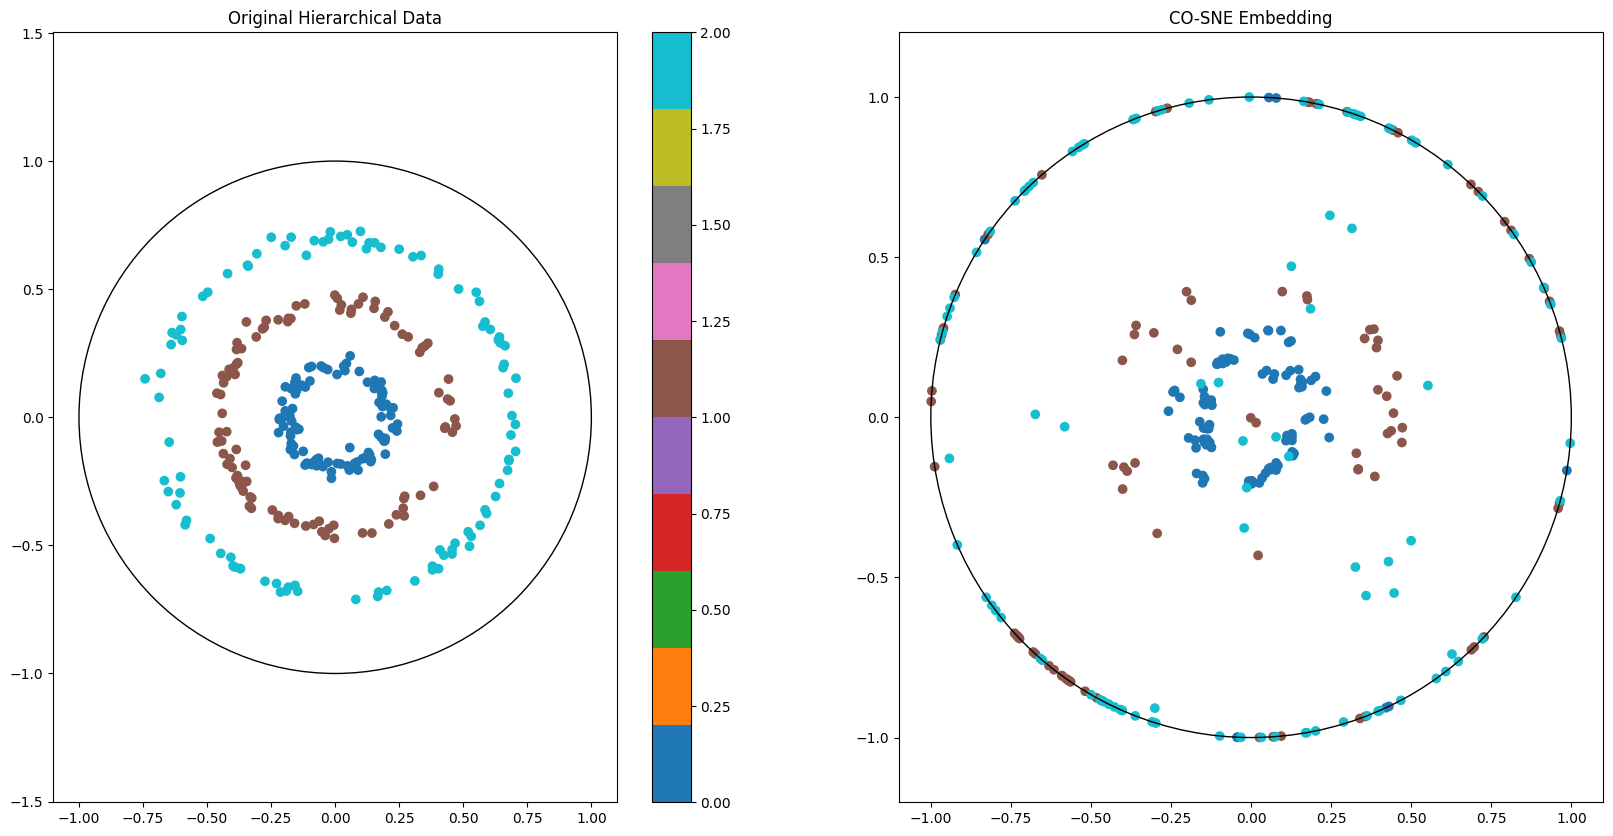

In [43]:
from time import time

# Generate synthetic data with more pronounced hierarchy
def generate_hierarchical_clusters(n_clusters=3, points_per_cluster=100):
    """Generate synthetic clusters with clearer hierarchical structure"""
    points = []
    labels = []

    for i in range(n_clusters):
        # More separated radii
        radius = 0.2 + (i * 0.25)  # This creates more distinct hierarchical levels

        # Generate points for this cluster with tighter distribution
        theta = np.random.uniform(0, 2*np.pi, points_per_cluster)
        r = radius + np.random.normal(0, 0.02, points_per_cluster)  # Reduced noise

        # Convert to Cartesian coordinates
        x = r * np.cos(theta)
        y = r * np.sin(theta)

        # Stack coordinates and add labels
        cluster_points = np.column_stack([x, y])
        points.append(cluster_points)
        labels.extend([i] * points_per_cluster)

    X = np.vstack(points)
    y = np.array(labels)

    return X, y

# Generate synthetic data
X, y = generate_hierarchical_clusters(n_clusters=3, points_per_cluster=100)

# Initialize and run CO-SNE with further adjusted parameters
cosne = TSNE(
    n_components=2,
    perplexity=15,
    learning_rate=25,
    n_iter=750,
    method='exact',
    init='random',
    verbose=2,
    early_exaggeration=2.0,
    student_t_gamma=0.25
)

print("Starting CO-SNE fitting...")
X_embedded = cosne.fit_transform(X, X)
print("CO-SNE fitting completed!")

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot original data
scatter1 = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10')
circle1 = plt.Circle((0, 0), 1, fill=False, color='black')
ax1.add_patch(circle1)
ax1.set_title('Original Hierarchical Data')
ax1.axis('equal')

# Plot CO-SNE embedding
scatter2 = ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='tab10')
circle2 = plt.Circle((0, 0), 1, fill=False, color='black')
ax2.add_patch(circle2)
ax2.set_title('CO-SNE Embedding')
ax2.axis('equal')

plt.colorbar(scatter1)
plt.show()

Generated 300 points
Starting CO-SNE fitting...
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.131815
[HT-SNE] Iteration 50: error = 4.8918725, gradient norm = 0.0108783 (50 iterations in 3.597s)
[HT-SNE] Iteration 100: error = 4.9673399, gradient norm = 0.0119686 (50 iterations in 3.142s)
[HT-SNE] Iteration 150: error = 4.7480169, gradient norm = 0.0147796 (50 iterations in 3.131s)
[HT-SNE] Iteration 200: error = 4.5895014, gradient norm = 0.0157190 (50 iterations in 2.846s)
[HT-SNE] Iteration 250: error = 4.6955461, gradient norm = 0.0153117 (50 iterations in 3.922s)
[HT-SNE] Iteration 300: error = 4.9858694, gradient norm = 0.0117145 (50 iterations in 3.551s)
[HT-SNE] Iteration 350: error = 4.8135883, gradient norm = 0.0143343 (50 iterations in 3.478s)
[HT-SNE] Iteration 400: error = 4.8471489, gradient norm = 0.0140336 (50 iterations in 3.749s)
[HT-SNE] Iteration 450: error = 4.5730571, gradient norm = 0

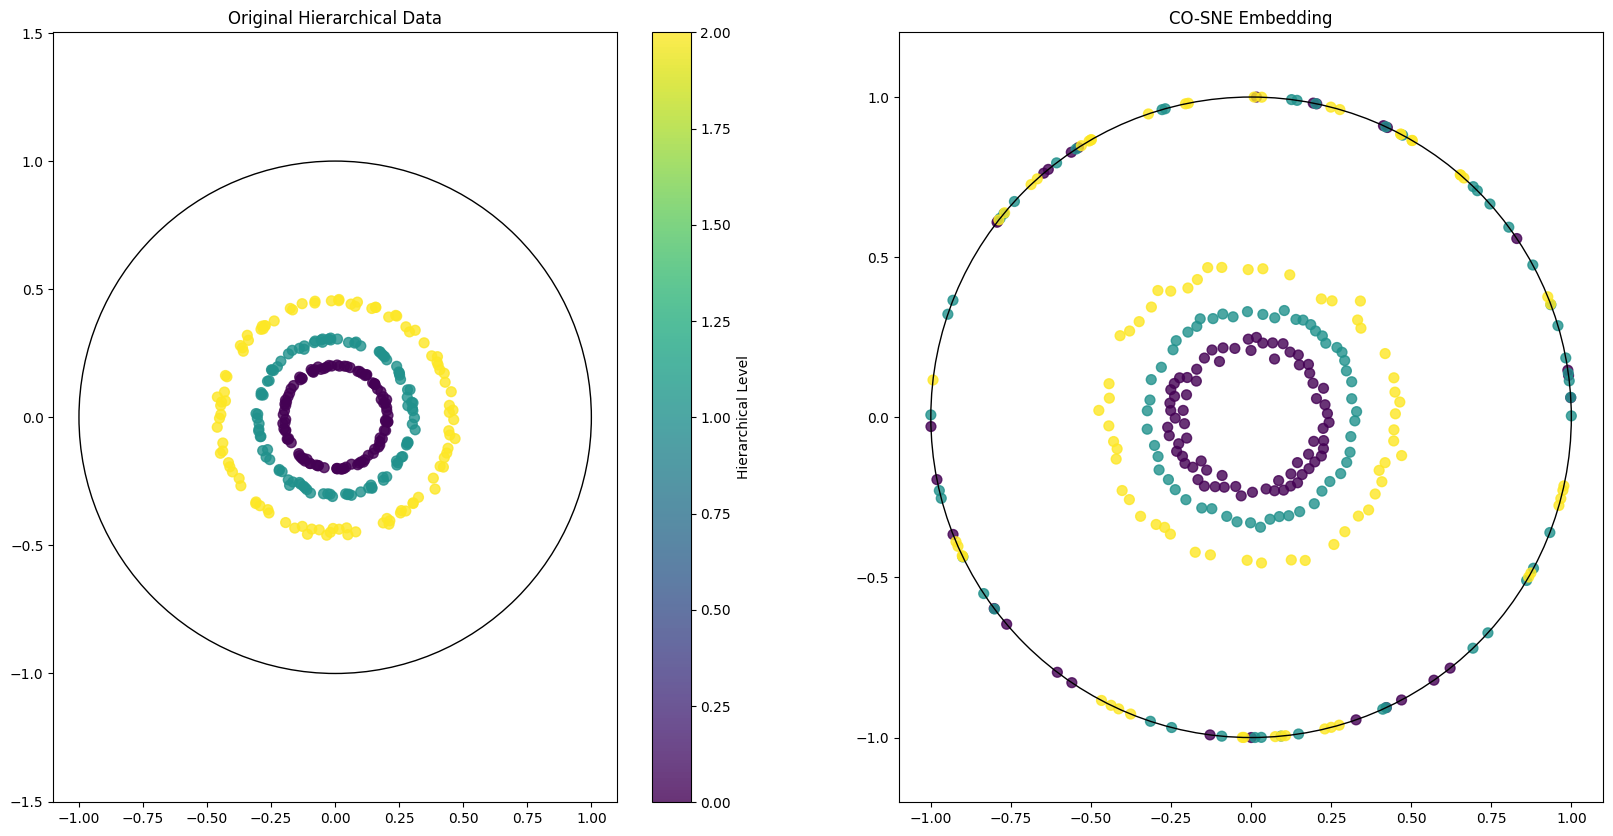

In [44]:
from time import time

def generate_synthetic_tree_data(n_levels=3, points_per_level=100, noise=0.05):
    """Generate synthetic hierarchical data with clearer structure"""
    points = []
    labels = []

    # Generate points level by level with increasing radii
    for level in range(n_levels):
        # Radius increases exponentially with level to create clearer hierarchy
        base_radius = 0.2 * (1.5 ** level)  # More pronounced radius increase

        # Generate points for this level
        angles = np.linspace(0, 2*np.pi, points_per_level) + np.random.normal(0, 0.1, points_per_level)
        radii = base_radius + np.random.normal(0, noise * base_radius, points_per_level)

        # Convert to Cartesian coordinates
        x = radii * np.cos(angles)
        y = radii * np.sin(angles)

        # Add points
        level_points = np.column_stack([x, y])
        points.append(level_points)
        labels.extend([level] * points_per_level)

    X = np.vstack(points)
    y = np.array(labels)

    # Ensure points are within the unit disk
    norms = np.sqrt(np.sum(X**2, axis=1))
    X = X / np.maximum(norms[:, np.newaxis], 0.99)

    return X, y

# Generate synthetic data
X, y = generate_synthetic_tree_data(n_levels=3, points_per_level=100, noise=0.02)

print(f"Generated {len(X)} points")

# Initialize and run CO-SNE with adjusted parameters
cosne = TSNE(
    n_components=2,
    perplexity=50,         # Increased to capture more global structure
    learning_rate=50,      # Reduced for stability
    n_iter=1000,
    method='exact',
    init='random',
    verbose=2,
    early_exaggeration=2.0,  # Reduced early exaggeration
    student_t_gamma=0.1      # Reduced gamma for better hierarchy preservation
)

print("Starting CO-SNE fitting...")
X_embedded = cosne.fit_transform(X, X)
print("CO-SNE fitting completed!")

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot original data
scatter1 = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, alpha=0.8)
circle1 = plt.Circle((0, 0), 1, fill=False, color='black')
ax1.add_patch(circle1)
ax1.set_title('Original Hierarchical Data')
ax1.axis('equal')
ax1.set_xlim([-1.1, 1.1])
ax1.set_ylim([-1.1, 1.1])

# Plot CO-SNE embedding
scatter2 = ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', s=50, alpha=0.8)
circle2 = plt.Circle((0, 0), 1, fill=False, color='black')
ax2.add_patch(circle2)
ax2.set_title('CO-SNE Embedding')
ax2.axis('equal')
ax2.set_xlim([-1.1, 1.1])
ax2.set_ylim([-1.1, 1.1])

plt.colorbar(scatter1, label='Hierarchical Level')
plt.show()

### TODO: Spherical SNE on Wrapped Normal Distribution (establishing spherical visualization)

### TODO: Decomposed Visualization of Mixed-Curvature Data (S² × E² × H²)